# Предсказание вероятности снижения покупательской активности

## Шаг 1. Загрузка данных

### Начнем работу с датасетами

Произведем необходимые импорты

In [21]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, 
    OneHotEncoder, OrdinalEncoder,
)

from sklearn.metrics import (
    confusion_matrix, 
    roc_curve,
    roc_auc_score
)

In [22]:
!pip install shap -q

In [23]:
try:
    import shap
except ModuleNotFoundError:
    !pip install shap
    import shap

Создадим функции для работы

In [24]:
# функция вывода информации о датасете
def dataset_info(dataset):
    display(dataset.info())
    display(dataset.describe())
    display(dataset.head())

In [25]:
# функция для проверки на дубликаты и вывода значений
def get_duplcate():
    
    dataframes = {
        'market_file': market_file,
        'market_money': market_money,
        'market_time': market_time,
        'money': money
    }
    
    for name, df in dataframes.items():
        print(
            f'Дубликатов в датафрейме {name}:', 
            df.duplicated().sum(), '- это', 
            round((df.duplicated().sum() / len(df)), 2), 'от всех данных'
    )

Загрузим данные

In [26]:
pd.set_option('display.max_columns', None) # установим опцию по выводу всех колонок датафрейма

# укажем формат отображения больших чисел,
pd.set_option('display.float_format', '{:.2f}'.format) # чтобы не применялась экспоненциальная запись в таблицах

In [27]:
# прочитаем файлы

market_file = pd.read_csv('data/market_file.csv', sep= ',')
market_money = pd.read_csv('data/market_money.csv', sep= ',')
market_time = pd.read_csv('data/market_time.csv', sep= ',')
money = pd.read_csv('data/money.csv', sep= ';')


### Изучим общую информацию о каждом датафрейме

In [28]:
dataset_info(market_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00
mean,215997.50,4.25,4.01,601.90,0.32,3.27,2.84,4.19,8.18
std,375.42,1.01,0.70,249.86,0.25,1.36,1.97,1.96,3.98
min,215348.00,0.90,3.00,110.00,0.00,1.00,0.00,0.00,1.00
25%,215672.75,3.70,4.00,405.50,0.17,2.00,1.00,3.00,5.00
50%,215997.50,4.20,4.00,606.00,0.24,3.00,3.00,4.00,8.00
75%,216322.25,4.90,4.00,806.00,0.30,4.00,4.00,6.00,11.00
max,216647.00,6.60,5.00,1079.00,0.99,6.00,10.00,9.00,20.00


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2


In [29]:
dataset_info(market_money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

,id,Выручка
count,3900.00,3900.00
mean,215997.50,5025.70
std,375.33,1777.70
min,215348.00,0.00
25%,215672.75,4590.15
50%,215997.50,4957.50
75%,216322.25,5363.00
max,216647.00,106862.20


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,3293.10
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,4472.00
4,215349,текущий_месяц,4971.60


In [30]:
dataset_info(market_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

,id,минут
count,2600.00,2600.00
mean,215997.50,13.34
std,375.35,4.08
min,215348.00,4.00
25%,215672.75,10.00
50%,215997.50,13.00
75%,216322.25,16.00
max,216647.00,23.00


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [31]:
dataset_info(money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


None

,id
count,1300.00
mean,215997.50
std,375.42
min,215348.00
25%,215672.75
50%,215997.50
75%,216322.25
max,216647.00


,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


**Вывод:** Пропусков в данных нет. В датафрейме `money` нужно преобразовать тип в столбце `'Прибыль'`.

## Шаг 2. Предобработка данных

### Изменение типов данных

В столбце `'Прибыль'` датафрейма `money` указана среднемесячная прибыль от покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. Так как магазин российский, то валюта расчета - рубли. Значит, запятыми в датафрейме могут быть отделены тысячи рублей. Преобразуем значения.

In [32]:
money['Прибыль'] = (money['Прибыль'].str.replace(',', '.').astype(float)) * 1000

# проверим результат
money.head()

,id,Прибыль
0,215348,980.00
1,215349,4160.00
2,215350,3130.00
3,215351,4870.00
4,215352,4210.00


### Исследуем данные на дубликаты

In [33]:
get_duplcate()

Дубликатов в датафрейме market_file: 0 - это 0.0 от всех данных
Дубликатов в датафрейме market_money: 0 - это 0.0 от всех данных
Дубликатов в датафрейме market_time: 0 - это 0.0 от всех данных
Дубликатов в датафрейме money: 0 - это 0.0 от всех данных


Явных дубликатов в данных нет.

### Проверим уникальные значения в столбцах

В датафрейме `market_file`

In [34]:
print('В столбце \'Покупательская активность\':', len(market_file['Покупательская активность'].unique()))
print(market_file['Покупательская активность'].value_counts())

В столбце 'Покупательская активность': 2
Покупательская активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64


In [35]:
print('В столбце \'Покупательская активность\':', len(market_file['Покупательская активность'].unique()))
print(market_file['Покупательская активность'].value_counts())

В столбце 'Покупательская активность': 2
Покупательская активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64


In [36]:
print('В столбце \'Тип сервиса\':', len(market_file['Тип сервиса'].unique()))
print(market_file['Тип сервиса'].value_counts())

В столбце 'Тип сервиса': 3
Тип сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64


In [37]:
print('В столбце \'Разрешить сообщать\':', len(market_file['Разрешить сообщать'].unique()))
print(market_file['Разрешить сообщать'].value_counts())

В столбце 'Разрешить сообщать': 2
Разрешить сообщать
да     962
нет    338
Name: count, dtype: int64


In [38]:
print('В столбце \'Популярная_категория\':', len(market_file['Популярная_категория'].unique()))
print(market_file['Популярная_категория'].value_counts())

В столбце 'Популярная_категория': 6
Популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64


In [39]:
# устраним неявные дубликаты
market_file['Тип сервиса'] = market_file['Тип сервиса'].str.replace ('стандартт', 'стандарт')
# проверим результат
print(market_file['Тип сервиса'].value_counts())

Тип сервиса
стандарт    924
премиум     376
Name: count, dtype: int64


В датафрейме `market_money`

In [40]:
print('В столбце \'Период\':', len(market_money['Период'].unique()))
print(market_money['Период'].value_counts())

В столбце 'Период': 3
Период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64


В датафрейме `market_time`

In [41]:
print('В столбце \'Период\':', len(market_time['Период'].unique()))
print(market_time['Период'].value_counts())

В столбце 'Период': 2
Период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64


In [42]:
# устраним опечатку в названии
market_time['Период'] = market_time['Период'].str.replace ('предыдцщий_месяц', 'предыдущий_месяц')
# проверим результат
print(market_time['Период'].value_counts())

Период
текущий_месяц       1300
предыдущий_месяц    1300
Name: count, dtype: int64


### Переименование столбцов

In [43]:
market_file.rename(
    columns = {
        'Покупательская активность':'Покупательская_активность', 
        'Тип сервиса':'Тип_сервиса', 
        'Разрешить сообщать':'Разрешить_сообщать'  
    }, inplace=True)

# проверим результат
market_file.columns

Index(['id', 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

**Вывод:** На этапе предобработки данных не выявлено явных дубликатов. Устранены неявные дубликаты в столбце `'Тип сервиса'` датафрейма `market_file`, а также устранена опечатка в значении в столбце `'Период'` датафрейма `market_time`. Для удобства дальнейшего использования переименовали некоторые столбцы.

## Шаг 3. Исследовательский анализ данных

### Проведем статистический анализ количественных признаков

#### В датафрейме `market_file`

Text(0, 0.5, 'Коммуникации')

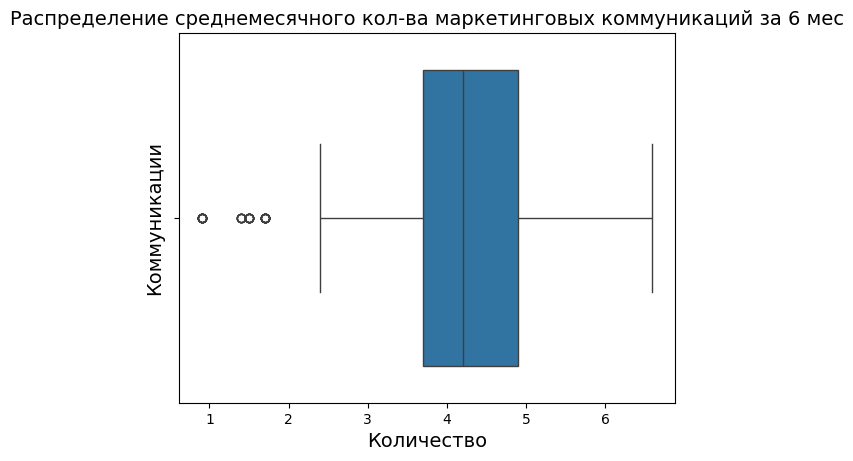

In [44]:
boxplot = sns.boxplot(x=market_file['Маркет_актив_6_мес'])
boxplot.axes.set_title('Распределение среднемесячного кол-ва маркетинговых коммуникаций за 6 мес', fontsize=14)
boxplot.set_xlabel('Количество', fontsize=14)
boxplot.set_ylabel('Коммуникации', fontsize=14)

In [45]:
market_file_low = market_file[market_file['Покупательская_активность'] == 'Снизилась']
market_file_norm = market_file[market_file['Покупательская_активность'] == 'Прежний уровень']

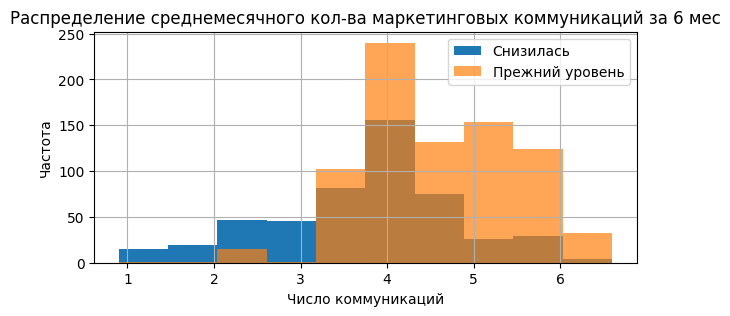

In [140]:
ax = market_file_low['Маркет_актив_6_мес'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 10, label='Снизилась')
ax = market_file_norm['Маркет_актив_6_мес'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 10, alpha= 0.7, label='Прежний уровень')
plt.title('Распределение среднемесячного кол-ва маркетинговых коммуникаций за 6 мес')
plt.xlabel('Число коммуникаций')
plt.ylabel('Частота')
plt.legend(loc='upper right')
plt.show()

Редкость - меньше двух коммуникаций в месяц; обычно это около 4 коммуникаций. Распределение похоже на нормальное.

Text(0, 0.5, 'Дни')

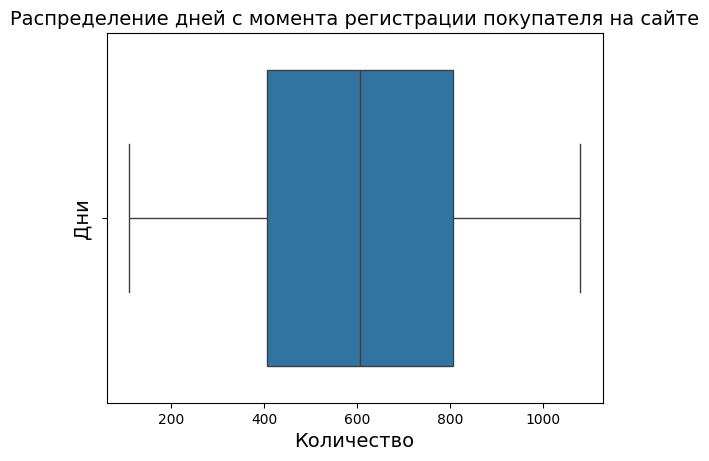

In [47]:
boxplot = sns.boxplot(x=market_file['Длительность'])
boxplot.axes.set_title('Распределение дней с момента регистрации покупателя на сайте', fontsize=14)
boxplot.set_xlabel('Количество', fontsize=14)
boxplot.set_ylabel('Дни', fontsize=14)

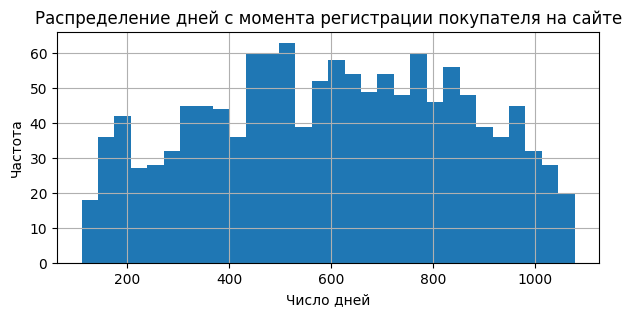

In [48]:
market_file['Длительность'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 30)
plt.title('Распределение дней с момента регистрации покупателя на сайте')
plt.xlabel('Число дней')
plt.ylabel('Частота')
plt.show()

Больше всего данных лежит в промежутке от 400 до 800 дней.

Text(0, 0.5, 'Покупки')

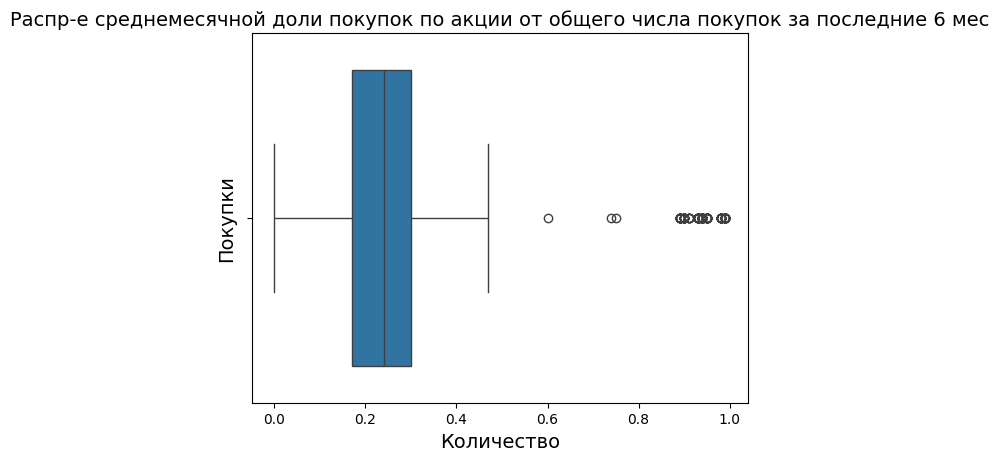

In [49]:
boxplot = sns.boxplot(x=market_file['Акционные_покупки'])
boxplot.axes.set_title('Распр-е среднемесячной доли покупок по акции от общего числа покупок за последние 6 мес', fontsize=14)
boxplot.set_xlabel('Количество', fontsize=14)
boxplot.set_ylabel('Покупки', fontsize=14)

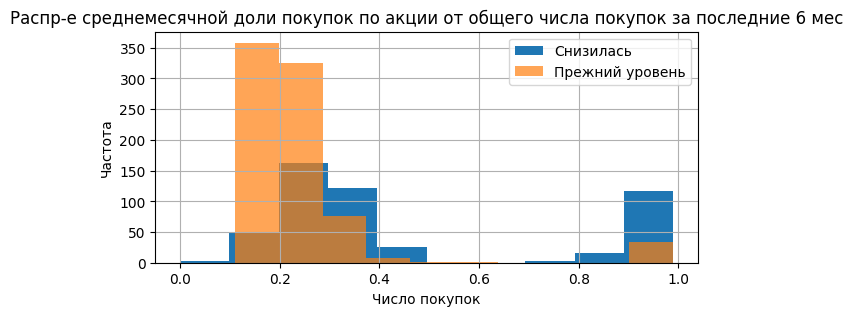

In [142]:
ax = market_file_low['Акционные_покупки'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 10, label='Снизилась')
ax = market_file_norm['Акционные_покупки'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 10, alpha= 0.7, label='Прежний уровень')
plt.title('Распр-е среднемесячной доли покупок по акции от общего числа покупок за последние 6 мес')
plt.xlabel('Число покупок')
plt.ylabel('Частота')
plt.legend(loc='upper right')
plt.show()

Обычно доля акционных покупок составляет около 25%. При этом есть незначительное количество покупателей, которые покупают по акции в 60% случаев, а также можно выделить в отдельную категорию тех, кто делает покупки в основном по акции (80-99%).

In [51]:
# посмотрим соотношение значений
market_file_low_act = market_file_low.pivot_table(
    index= 'Маркет_актив_тек_мес', 
    values= 'id', aggfunc= 'count'
).sort_values(by='id', ascending = True).reset_index()

market_file_low_act

,Маркет_актив_тек_мес,id
0,3,122
1,5,128
2,4,248


In [52]:
# посмотрим соотношение значений
market_file_norm_act = market_file_norm.pivot_table(
    index= 'Маркет_актив_тек_мес', 
    values= 'id', aggfunc= 'count'
).sort_values(by='id', ascending = True).reset_index()

market_file_norm_act

,Маркет_актив_тек_мес,id
0,3,186
1,5,195
2,4,421


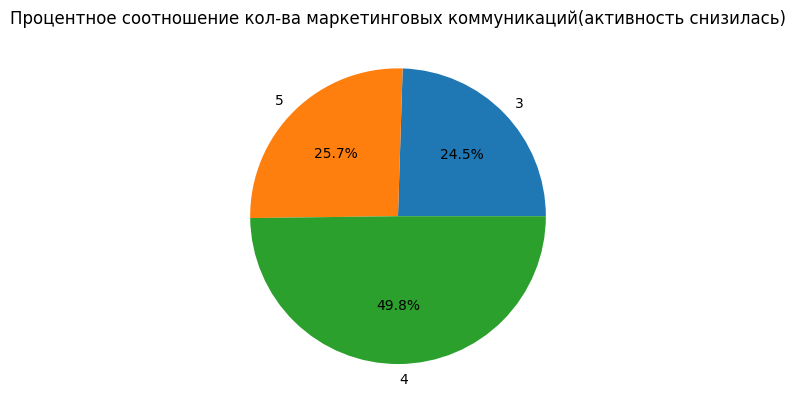

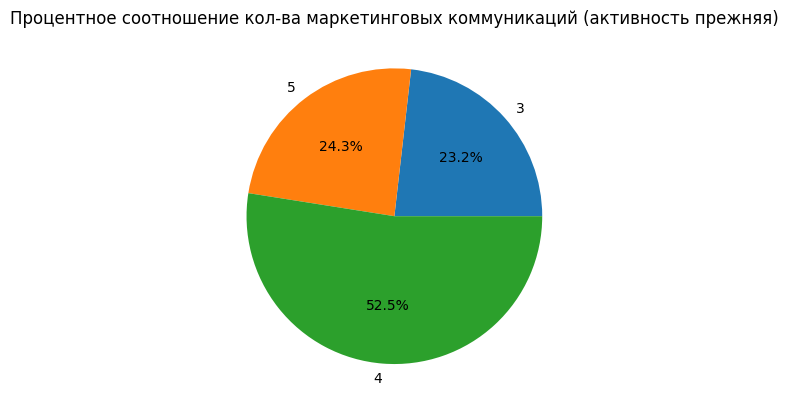

In [53]:
# построим круговую диаграмму
fig, ax = plt.subplots()
ax.pie(market_file_low_act['id'], labels= market_file_low_act['Маркет_актив_тек_мес'], autopct='%1.1f%%')
plt.title('Процентное соотношение кол-ва маркетинговых коммуникаций(активность снизилась)')

fig, ax = plt.subplots()
ax.pie(market_file_norm_act['id'], labels=market_file_norm_act['Маркет_актив_тек_мес'], autopct='%1.1f%%')
plt.title('Процентное соотношение кол-ва маркетинговых коммуникаций (активность прежняя)')

plt.show()

In [54]:
# посмотрим соотношение значений
market_file_low_cat = market_file_low.pivot_table(
    index= 'Средний_просмотр_категорий_за_визит', 
    values= 'id', aggfunc= 'count'
).sort_values(by='id', ascending = True).reset_index()

market_file_low_cat

,Средний_просмотр_категорий_за_визит,id
0,6,16
1,5,25
2,4,63
3,1,84
4,3,134
5,2,176


In [55]:
# посмотрим соотношение значений
market_file_norm_cat = market_file_norm.pivot_table(
    index= 'Средний_просмотр_категорий_за_визит', 
    values= 'id', aggfunc= 'count'
).sort_values(by='id', ascending = True).reset_index()

market_file_norm_cat

,Средний_просмотр_категорий_за_визит,id
0,1,22
1,6,70
2,2,136
3,5,152
4,4,200
5,3,222


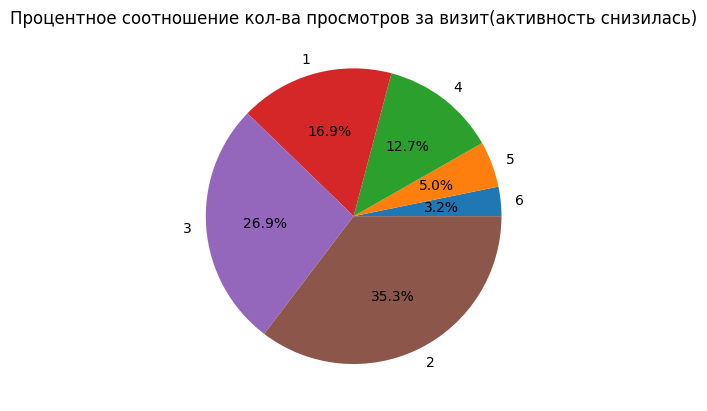

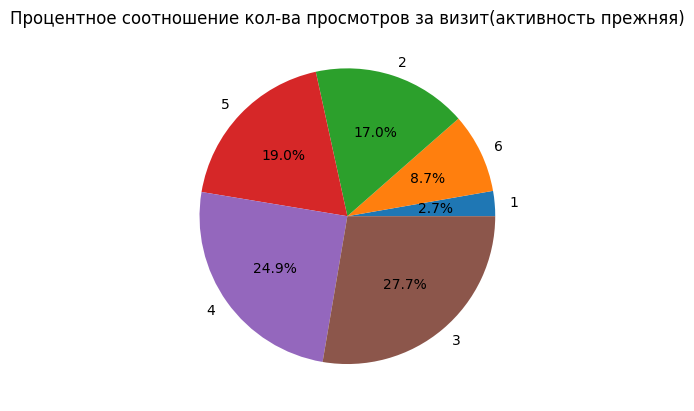

In [56]:
# построим круговую диаграмму
fig, ax = plt.subplots()
ax.pie(market_file_low_cat['id'], labels=market_file_low_cat['Средний_просмотр_категорий_за_визит'], autopct='%1.1f%%')
plt.title('Процентное соотношение кол-ва просмотров за визит(активность снизилась)')

fig, ax = plt.subplots()
ax.pie(market_file_norm_cat['id'], labels=market_file_norm_cat['Средний_просмотр_категорий_за_визит'], autopct='%1.1f%%')
plt.title('Процентное соотношение кол-ва просмотров за визит(активность прежняя)')
plt.show()

In [57]:
# посмотрим соотношение значений
market_file_low_prod = market_file_low.pivot_table(
    index= 'Неоплаченные_продукты_штук_квартал', 
    values= 'id', aggfunc= 'count'
).sort_values(by='id', ascending = True)

market_file_norm_prod = market_file_norm.pivot_table(
    index= 'Неоплаченные_продукты_штук_квартал', 
    values= 'id', aggfunc= 'count'
).sort_values(by='id', ascending = True)

market_file_prod = market_file_low_prod.merge(market_file_norm_prod, on='Неоплаченные_продукты_штук_квартал', how='right')
market_file_prod.rename(
    columns = {'id_x':'Снизилась', 'id_y':'Прежний уровень'}, inplace=True)

market_file_prod

,Снизилась,Прежний уровень
Неоплаченные_продукты_штук_квартал,,
8,19,1
7,32,2
6,41,3
5,71,64
0,29,87
4,75,122
3,73,145
2,83,178
1,61,200


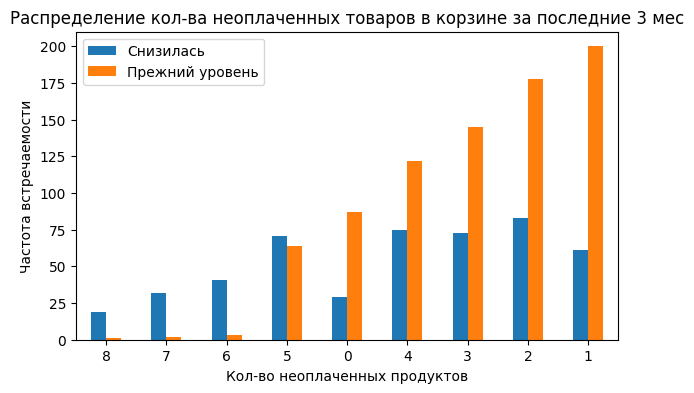

In [58]:
market_file_prod.plot(kind='bar', figsize = (7,4), legend= True, rot=0)
plt.title('Распределение кол-ва неоплаченных товаров в корзине за последние 3 мес')
plt.xlabel('Кол-во неоплаченных продуктов')
plt.ylabel('Частота встречаемости')
plt.show()

Большинство покупателей оставляют 1-2 неоплаченных товара в корзине, около половины покупателей оплачивают все товары, и только 1% покупателей оставляют неоплаченными 9-10 товаров.

In [59]:
# посмотрим соотношение значений
market_file_low_err = market_file_low.pivot_table(
    index= 'Ошибка_сервиса', 
    values= 'id', aggfunc= 'count'
).sort_values(by='id', ascending = True)

market_file_norm_err = market_file_norm.pivot_table(
    index= 'Ошибка_сервиса', 
    values= 'id', aggfunc= 'count'
).sort_values(by='id', ascending = True)

market_file_err = market_file_low_err.merge(market_file_norm_err, on='Ошибка_сервиса', how='right')
market_file_err.rename(
    columns = {'id_x':'Снизилась', 'id_y':'Прежний уровень'}, inplace=True)

market_file_err

,Снизилась,Прежний уровень
Ошибка_сервиса,,
9,3.00,12
0,NaN,17
1,32.00,42
8,23.00,43
7,36.00,56
2,96.00,93
6,43.00,113
3,106.00,120
5,65.00,143


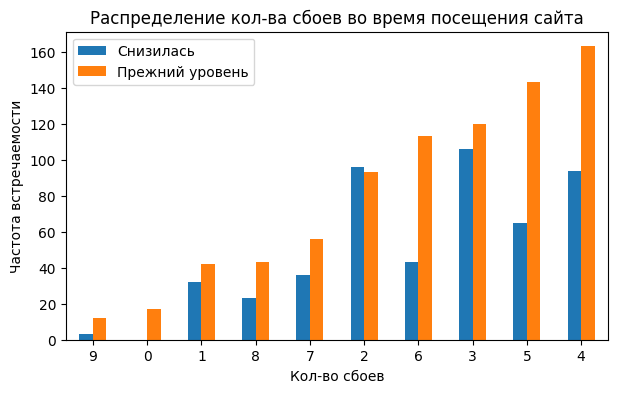

In [60]:
market_file_err.plot(kind='bar', figsize = (7,4), legend= True, rot=0)
plt.title('Распределение кол-ва сбоев во время посещения сайта')
plt.xlabel('Кол-во сбоев')
plt.ylabel('Частота встречаемости')
plt.show()

В основном за время посещения сайта происходит от 3 до 5 сбоев в его работе. Самые редкие ситуации вообще без сбоев и когда сбоев больше 8.

In [61]:
market_file_low_str = market_file_low.pivot_table(
    index= 'Страниц_за_визит', 
    values= 'id', aggfunc= 'count'
).sort_values(by='id', ascending = True)

market_file_norm_str = market_file_norm.pivot_table(
    index= 'Страниц_за_визит', 
    values= 'id', aggfunc= 'count'
).sort_values(by='id', ascending = True)

market_file_str = market_file_low_str.merge(market_file_norm_str, on='Страниц_за_визит', how='right')
market_file_str.rename(
    columns = {'id_x':'Снизилась', 'id_y':'Прежний уровень'}, inplace=True)

market_file_str

,Снизилась,Прежний уровень
Страниц_за_визит,,
20,NaN,2
19,NaN,5
18,1.00,6
3,68.00,8
17,6.00,13
16,4.00,17
15,5.00,31
4,79.00,33
5,80.00,35


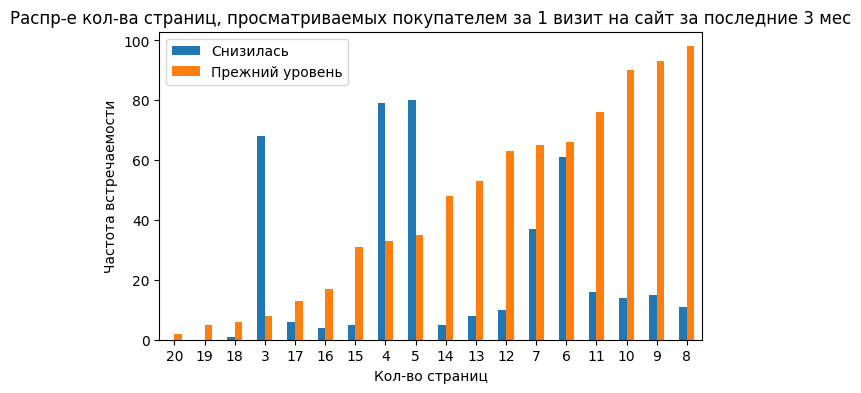

In [62]:
market_file_str.plot(kind='bar', figsize = (7,4), legend= True, rot=0)
plt.title('Распр-е кол-ва страниц, просматриваемых покупателем за 1 визит на сайт за последние 3 мес')
plt.xlabel('Кол-во страниц')
plt.ylabel('Частота встречаемости')
plt.show()

В основном покупатели просматривают от 4 до 6 страниц за 1 визит, только 1.5% покупателей ограничиваются одной страницей и примерно 1% просматривает больше 17 страниц.

#### В датафрейме `market_money`

Text(0, 0.5, 'Коммуникации')

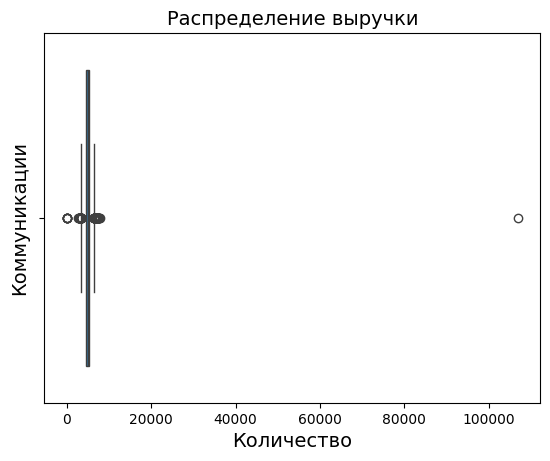

In [63]:
boxplot = sns.boxplot(x=market_money['Выручка'])
boxplot.axes.set_title('Распределение выручки', fontsize=14)
boxplot.set_xlabel('Количество', fontsize=14)
boxplot.set_ylabel('Коммуникации', fontsize=14)

In [64]:
display(market_money.query('Выручка > 100000'))
display(market_money.query('Выручка == 0'))
print('Строки с нулевой выручкой от общего кол-ва данных:', 
        round(len(market_money.query('Выручка == 0')) / len(market_money), 4)
       )

,id,Период,Выручка
98,215380,текущий_месяц,106862.20


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.00
2,215348,предыдущий_месяц,0.00
28,215357,препредыдущий_месяц,0.00
29,215357,предыдущий_месяц,0.00
34,215359,предыдущий_месяц,0.00
35,215359,препредыдущий_месяц,0.00


Строки с нулевой выручкой от общего кол-ва данных: 0.0015


В данных обнаружены выбросы. Можно допустить, что покупатель сделал выручку магазину в текущем месяце на сумму свыше 100 тыс. руб., но такое поведение единично, нестандартно. Попробуем заменить это значение на медианное.

Также можно допустить, что покупатели в течение месяца не принесли выручки магазину. Для дальшейшей работы нам не понадобятся эти данные, для удобства исследования удалим все строки с этими id.

In [65]:
market_money['Выручка'] = market_money['Выручка'].replace(106862.20, market_money['Выручка'].median())

# проверим результат
market_money.loc[[98]]

,id,Период,Выручка
98,215380,текущий_месяц,4957.50


In [66]:
market_money.drop(
    market_money.loc[
        ((market_money['id'] == 215348) | (market_money['id'] == 215357) | (market_money['id'] == 215359))
    ].index, inplace=True
)

# проверим результат
display(market_money.query('Выручка == 0'))
print('Строк в таблице market_money:', len(market_money))

,id,Период,Выручка


Строк в таблице market_money: 3891


Так как далее нам придётся работать сразу с несколькими таблицами по 'id' клиентов, удалим их и из других таблиц.

In [67]:
market_file.loc[((market_file['id'] == 215348) | (market_file['id'] == 215357) | (market_file['id'] == 215359))]

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
9,215357,Снизилась,стандарт,да,3.90,5,154,0.00,Техника для красоты и здоровья,3,3,9,5
11,215359,Снизилась,стандарт,да,4.60,5,110,0.00,Домашний текстиль,4,2,4,2


In [68]:
market_file.drop(market_file.loc[((market_file['id'] == 215348) | (market_file['id'] == 215357) | (market_file['id'] == 215359))].index, inplace=True)

# проверим результат
display(market_file.loc[((market_file['id'] == 215348) | (market_file['id'] == 215357) | (market_file['id'] == 215359))])
print('Строк в таблице market_file:', len(market_file))

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит


Строк в таблице market_file: 1297


In [69]:
market_time.loc[((market_time['id'] == 215348) | (market_time['id'] == 215357) | (market_time['id'] == 215359))]

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
18,215357,предыдущий_месяц,12
19,215357,текущий_месяц,6
22,215359,предыдущий_месяц,13
23,215359,текущий_месяц,11


In [70]:
market_time.drop(market_time.loc[((market_time['id'] == 215348) | (market_time['id'] == 215357) | (market_time['id'] == 215359))].index, inplace=True)

# проверим результат
display(market_time.loc[((market_time['id'] == 215348) | (market_time['id'] == 215357) | (market_time['id'] == 215359))])
print('Строк в таблице market_time:', len(market_time))

,id,Период,минут


Строк в таблице market_time: 2594


In [71]:
money.loc[((money['id'] == 215348) | (money['id'] == 215357) | (money['id'] == 215359))]

,id,Прибыль
0,215348,980.00
9,215357,4660.00
11,215359,5080.00


In [72]:
money.drop(money.loc[((money['id'] == 215348) | (money['id'] == 215357) | (money['id'] == 215359))].index, inplace=True)

# проверим результат
display(money.loc[((money['id'] == 215348) | (money['id'] == 215357) | (money['id'] == 215359))])
print('Строк в таблице money:', len(money))

,id,Прибыль


Строк в таблице money: 1297


Продолжим исследование количественных признаков

Text(0, 0.5, 'Коммуникации')

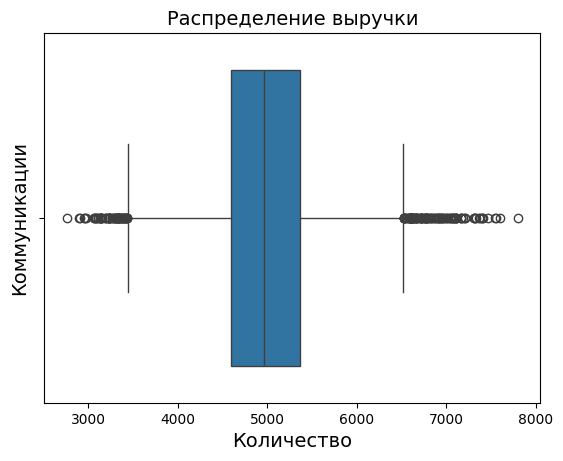

In [73]:
boxplot = sns.boxplot(x=market_money['Выручка'])
boxplot.axes.set_title('Распределение выручки', fontsize=14)
boxplot.set_xlabel('Количество', fontsize=14)
boxplot.set_ylabel('Коммуникации', fontsize=14)

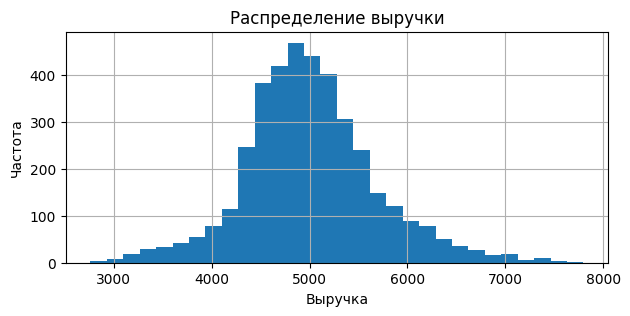

In [74]:
market_money['Выручка'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 30)
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.show()

Выручка распределена нормально.

#### В датафрейме `market_time`

Text(0, 0.5, 'Время')

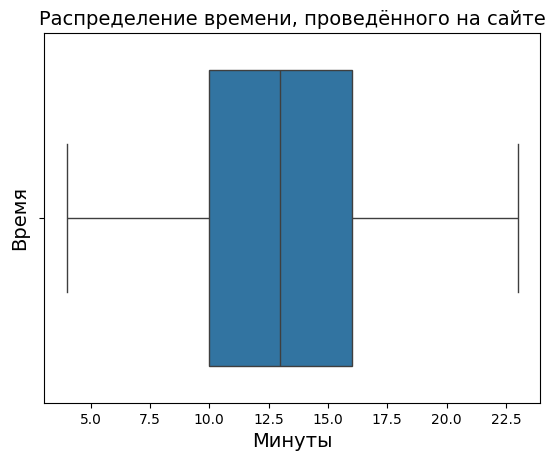

In [75]:
boxplot = sns.boxplot(x=market_time['минут'])
boxplot.axes.set_title('Распределение времени, проведённого на сайте', fontsize=14)
boxplot.set_xlabel('Минуты', fontsize=14)
boxplot.set_ylabel('Время', fontsize=14)

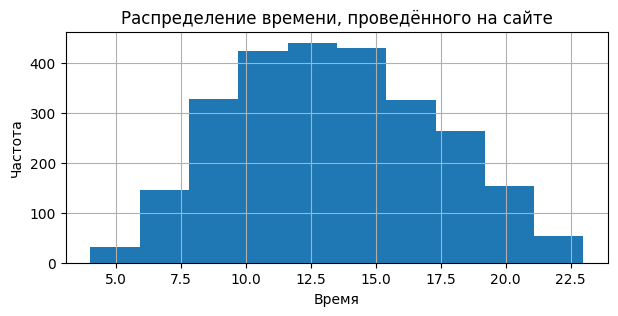

In [76]:
market_time['минут'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 10)
plt.title('Распределение времени, проведённого на сайте')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.show()

Распределение времени похоже на нормальное.

#### В датафрейме `money`

Text(0, 0.5, 'Прибыль')

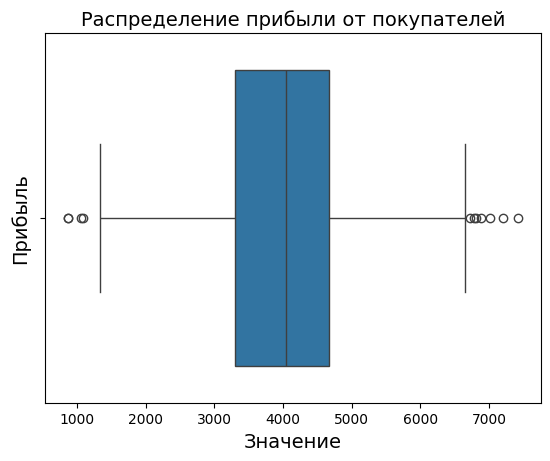

In [77]:
boxplot = sns.boxplot(x=money['Прибыль'])
boxplot.axes.set_title('Распределение прибыли от покупателей', fontsize=14)
boxplot.set_xlabel('Значение', fontsize=14)
boxplot.set_ylabel('Прибыль', fontsize=14)

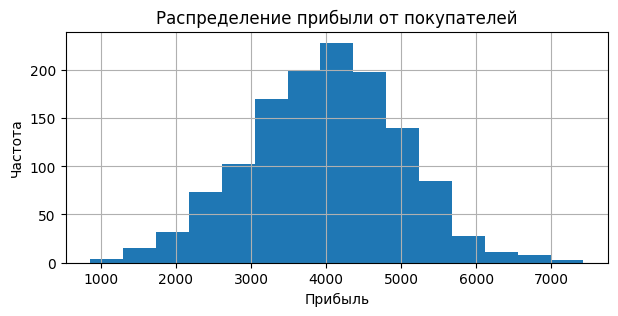

In [78]:
money['Прибыль'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 15)
plt.title('Распределение прибыли от покупателей')
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.show()

Прибыль распределена нормально.

### Проведем статистический анализ категориальных признаков

#### В датафрейме `market_file`

In [79]:
# посмотрим соотношение значений
market_file_buy = market_file.pivot_table(
    index= 'Покупательская_активность', 
    values= 'id', aggfunc= 'count'
).sort_values(by='id', ascending = True).reset_index()

market_file_buy

,Покупательская_активность,id
0,Снизилась,495
1,Прежний уровень,802


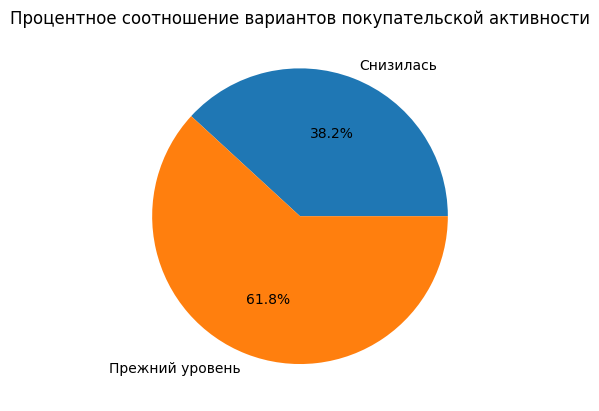

In [80]:
# построим круговую диаграмму
fig, ax = plt.subplots()
ax.pie(market_file_buy['id'], labels=market_file_buy['Покупательская_активность'], autopct='%1.1f%%')
plt.title('Процентное соотношение вариантов покупательской активности')
plt.show()

In [81]:
# посмотрим соотношение значений
market_file_serv = market_file.pivot_table(
    index= 'Тип_сервиса', 
    values= 'id', aggfunc= 'count'
).sort_values(by='id', ascending = True).reset_index()

market_file_serv

,Тип_сервиса,id
0,премиум,375
1,стандарт,922


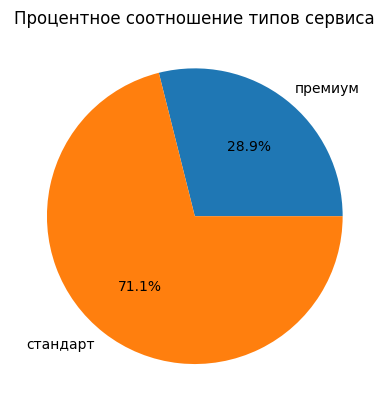

In [82]:
# построим круговую диаграмму
fig, ax = plt.subplots()
ax.pie(market_file_serv['id'], labels=market_file_serv['Тип_сервиса'], autopct='%1.1f%%')
plt.title('Процентное соотношение типов сервиса')
plt.show()

In [83]:
# посмотрим соотношение значений
market_file_mes = market_file.pivot_table(
    index= 'Разрешить_сообщать', 
    values= 'id', aggfunc= 'count'
).sort_values(by='id', ascending = True).reset_index()

market_file_mes

,Разрешить_сообщать,id
0,нет,338
1,да,959


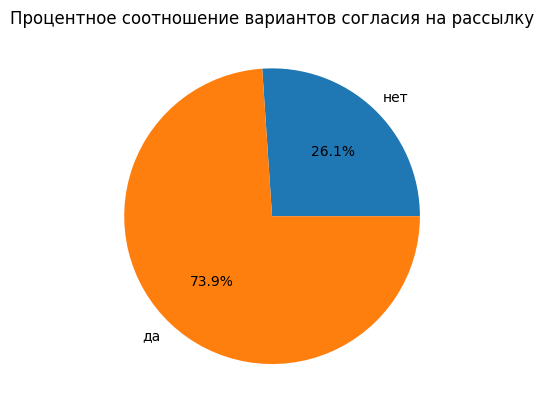

In [84]:
# построим круговую диаграмму
fig, ax = plt.subplots()
ax.pie(market_file_mes['id'], labels=market_file_mes['Разрешить_сообщать'], autopct='%1.1f%%')
plt.title('Процентное соотношение вариантов согласия на рассылку')
plt.show()

In [85]:
# посмотрим соотношение значений
market_file_goods = market_file.pivot_table(
    index= 'Популярная_категория', 
    values= 'id', aggfunc= 'count'
).sort_values(by='id', ascending = True).reset_index()

market_file_goods

,Популярная_категория,id
0,Кухонная посуда,138
1,Мелкая бытовая техника и электроника,174
2,Техника для красоты и здоровья,183
3,Косметика и аксесуары,223
4,Домашний текстиль,250
5,Товары для детей,329


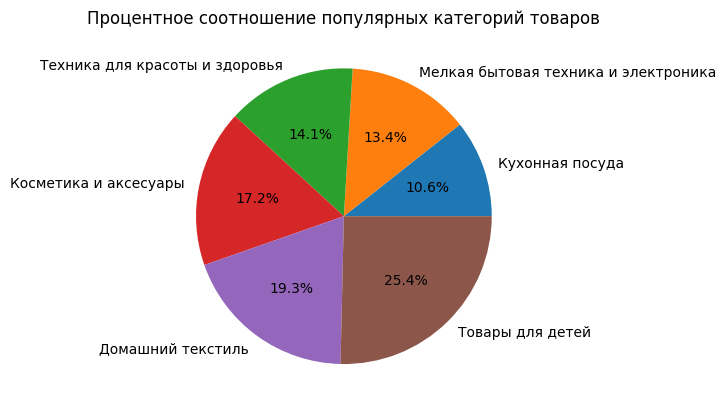

In [86]:
# построим круговую диаграмму
fig, ax = plt.subplots()
ax.pie(market_file_goods['id'], labels=market_file_goods['Популярная_категория'], autopct='%1.1f%%')
plt.title('Процентное соотношение популярных категорий товаров')
plt.show()

#### В датафрейме `market_money`

In [87]:
# посмотрим соотношение значений
market_money_per = market_money.pivot_table(
    index= 'Период', 
    values= 'id', aggfunc= 'count'
).sort_values(by='id', ascending = True).reset_index()

market_money_per

,Период,id
0,предыдущий_месяц,1297
1,препредыдущий_месяц,1297
2,текущий_месяц,1297


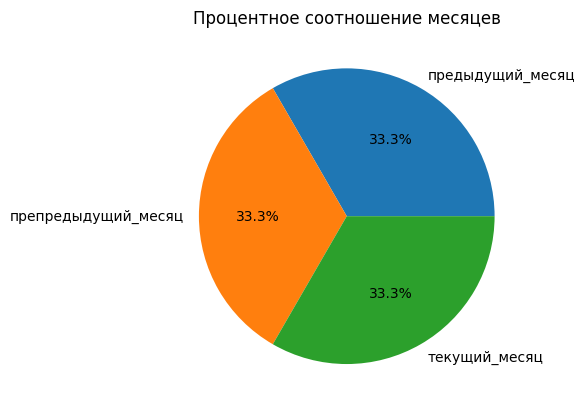

In [88]:
# построим круговую диаграмму
fig, ax = plt.subplots()
ax.pie(market_money_per['id'], labels=market_money_per['Период'], autopct='%1.1f%%')
plt.title('Процентное соотношение месяцев')
plt.show()

В данных представлено одинаковое количество наблюдений за каждый месяц.

#### В датафрейме `market_time`

In [89]:
# посмотрим соотношение значений
market_time_period = market_time.pivot_table(
    index= 'Период', 
    values= 'id', aggfunc= 'count'
).sort_values(by='id', ascending = True).reset_index()

market_time_period

,Период,id
0,предыдущий_месяц,1297
1,текущий_месяц,1297


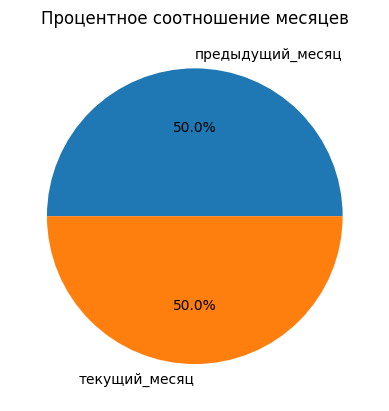

In [90]:
# построим круговую диаграмму
fig, ax = plt.subplots()
ax.pie(market_time_period['id'], labels=market_time_period['Период'], autopct='%1.1f%%')
plt.title('Процентное соотношение месяцев')
plt.show()

В данных представлено одинаковое количество наблюдений за 2 месяца.

**Вывод:** В ходе исследования количественных и категориальных признаков было выявлено:
- В среднем магазином проводится около 4 маркетинговых коммуникаций с покупателем в месяц, редко магазин ограничивается 1-2 коммуникациями. Маркетинговые коммуникации имеют нормальное распределение.
- Больше всего покупателей являются клиентами этого сайта от 1 до 2 лет.
- Доля акционных покупок составляет около 25%. При этом есть незначительное количество покупателей, которые покупают по акции в 60% случаев, а также можно выделить в отдельную категорию тех, кто делает покупки в основном по акции (80-99%).
- За 1 визит покупатели просматривают в основном от 2 до 4 категорий товаров. Только 8.2 % ограничиваются одной категорией, и 6.6% просматривают все 6 категорий.
- Большинство покупателей оставляют 1-2 неоплаченных товара в корзине, около половины покупателей оплачивают все товары, и только 1% покупателей оставляют неоплаченными 9-10 товаров.
- Всего лишь 1.3% посещений обходится без сбоев на сайте, обычно от 3 до 5 сбоев - это норма.
- Покупательская активность осталась на преждем уровне у 61.7% покупателей. Снижение наблюдаем в 38.3% случаев, это не критично, но, тем не менее, много.
- 28.9% покупателей имеют премиум сервис, и 74% покупателей дали согласие на рассылки.
- Из популярных категорий у покупателей лидируют товары для детей (25.4%) и домашний текстиль (19.3%).

### Проведем сегментацию покупателей

#### Выделим группу клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

In [91]:
clients_sale = market_file.query('Акционные_покупки > 0.5 & Покупательская_активность == "Снизилась"')
clients_sale

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
3,215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2
14,215362,Снизилась,премиум,да,4.20,4,438,0.74,Домашний текстиль,3,4,6,4
16,215364,Снизилась,премиум,да,4.30,4,708,0.98,Домашний текстиль,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,215910,Снизилась,стандарт,нет,3.90,3,509,0.95,Косметика и аксесуары,2,6,4,5
579,215927,Снизилась,стандарт,да,5.20,4,801,0.99,Кухонная посуда,2,1,4,9
585,215933,Снизилась,стандарт,да,4.60,4,316,0.95,Косметика и аксесуары,2,5,6,13
586,215934,Снизилась,стандарт,нет,5.50,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7


In [92]:
print(
    'Доля клиентов с максимальной долей покупок по акции и снижением покупательской активности:', 
    round(len(clients_sale)/len(market_file), 2)
)

Доля клиентов с максимальной долей покупок по акции и снижением покупательской активности: 0.1


Таким образом, количество клиентов со сниженной покупательской активностью, которые более 50% покупок совершают по акции, равно 10%.

#### Выделим группу клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

Для этого объединим два датафрейма `market_file` и `money` по столбцу `id`.

In [93]:
print('Строк в датафрейме market_file:', len(market_file))
print('Строк в датафрейме money:', len(money))

Строк в датафрейме market_file: 1297
Строк в датафрейме money: 1297


In [94]:
market = market_file.merge(money, on= 'id', how= 'left')

# проверим результат
market.head()

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Прибыль
0,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,4160.00
1,215350,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,3130.00
2,215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,4870.00
3,215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,4210.00
4,215353,Снизилась,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,3950.00


In [95]:
print('Строк в датафрейме market:', len(market))

Строк в датафрейме market: 1297


In [96]:
clients_profit = market.query('Прибыль > 4000 & Покупательская_активность == "Снизилась"')
clients_profit

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Прибыль
0,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,4160.00
2,215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,4870.00
3,215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,4210.00
6,215355,Снизилась,стандарт,нет,4.70,4,284,0.17,Товары для детей,5,1,6,4,5260.00
7,215356,Снизилась,стандарт,да,4.20,4,192,0.14,Косметика и аксесуары,2,2,1,3,4930.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,215929,Снизилась,премиум,да,4.00,4,599,0.15,Товары для детей,2,8,4,7,4040.00
580,215931,Снизилась,стандарт,нет,4.90,4,302,0.19,Кухонная посуда,1,5,3,7,5330.00
582,215933,Снизилась,стандарт,да,4.60,4,316,0.95,Косметика и аксесуары,2,5,6,13,4050.00
583,215934,Снизилась,стандарт,нет,5.50,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,4400.00


In [97]:
print(
    'Доля клиентов с наиболее высокой прибыльностью и снижением покупательской активности:', 
    round(len(clients_profit)/len(market), 2)
)

Доля клиентов с наиболее высокой прибыльностью и снижением покупательской активности: 0.2


#### Выделим группу клиентов, которые покупают товары с длинным жизненным циклом

In [98]:
clients_tech = market.query('Популярная_категория == ["Техника для красоты и здоровья", "Мелкая бытовая техника и электроника"] & Покупательская_активность == "Снизилась"')
clients_tech

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Прибыль
10,215361,Снизилась,стандарт,да,5.10,4,199,0.23,Техника для красоты и здоровья,4,5,2,3,4030.00
14,215365,Снизилась,стандарт,да,3.90,4,167,0.95,Техника для красоты и здоровья,6,4,2,5,3650.00
17,215368,Снизилась,премиум,да,3.80,5,829,0.24,Техника для красоты и здоровья,2,2,6,1,6270.00
27,215378,Снизилась,стандарт,да,1.70,3,488,0.39,Техника для красоты и здоровья,5,1,4,3,3030.00
29,215380,Снизилась,премиум,нет,1.70,4,637,0.94,Техника для красоты и здоровья,3,2,4,7,3880.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,215919,Снизилась,премиум,да,4.30,3,384,0.21,Мелкая бытовая техника и электроника,2,3,2,4,4620.00
574,215925,Снизилась,стандарт,нет,4.90,4,450,0.27,Мелкая бытовая техника и электроника,2,2,4,13,3400.00
583,215934,Снизилась,стандарт,нет,5.50,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,4400.00
585,215936,Снизилась,стандарт,да,3.90,3,567,0.24,Техника для красоты и здоровья,2,4,7,7,4490.00


In [99]:
print(
    'Доля клиентов, покупающих товары с длинным жизненным циклом и снижением покупательской активности:', 
    round(len(clients_tech)/len(market), 2)
)

Доля клиентов, покупающих товары с длинным жизненным циклом и снижением покупательской активности: 0.06


**Вывод:** На данном этапе мы выделили несколько групп покупателей:
- С максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности: ими оказались 10% от всех клиентов.
- С высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью: таких покупателей оказалось 20%.
- Клиенты, которые покупают товары с длинным жизненным циклом: это 6% от всего количества.

## Шаг 4. Объединение таблиц

In [100]:
# считаем сколько строк в каждой таблице
print('Строк в датафрейме market_file:', len(market_file))
print('Строк в датафрейме market_money:', len(market_money))
print('Строк в датафрейме market_time:', len(market_time))

Строк в датафрейме market_file: 1297
Строк в датафрейме market_money: 3891
Строк в датафрейме market_time: 2594


Для того, чтобы объединить таблицы, из таблиц с признаком 'Период' сделаем сводные.

In [101]:
pivot_market_money = market_money.pivot_table(index='id', columns='Период', values='Выручка', aggfunc='first').reset_index()
pivot_market_money.columns = ['id', 'Выручка_пред_мес', 'Выручка_препред_мес', 'Выручка_текущ_мес']
pivot_market_money.set_index('id', inplace = True)
pivot_market_money

,Выручка_пред_мес,Выручка_препред_мес,Выручка_текущ_мес
id,,,
215349,5216.00,4472.00,4971.60
215350,5457.50,4826.00,5058.40
215351,6158.00,4793.00,6610.40
215352,5807.50,4594.00,5872.50
215353,4738.50,5124.00,5388.50
...,...,...,...
216643,3664.00,4704.00,4741.70
216644,4729.00,5299.00,5353.00
216645,5160.00,5334.00,5139.20


In [102]:
pivot_market_time = market_time.pivot_table(index='id', columns='Период', values='минут', aggfunc='first').reset_index()
pivot_market_time.columns = ['id', 'Минут_пред_мес', 'Минут_текущ_мес']
pivot_market_time.set_index('id', inplace = True)
pivot_market_time

,Минут_пред_мес,Минут_текущ_мес
id,,
215349,12,10
215350,8,13
215351,11,13
215352,8,11
215353,10,10
...,...,...
216643,14,7
216644,12,11
216645,12,18


Проверим ещё раз на пропуски

In [103]:
market_file.isna().sum()

id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [104]:
pivot_market_time.isna().sum()

Минут_пред_мес     0
Минут_текущ_мес    0
dtype: int64

In [105]:
pivot_market_money.isna().sum()

Выручка_пред_мес       0
Выручка_препред_мес    0
Выручка_текущ_мес      0
dtype: int64

Объединим все таблицы

In [106]:
# сделаем индексами id
market_file.set_index('id', inplace = True) 

In [107]:
market_all = market_file.merge(pivot_market_money, on = 'id')

# проверим результат
market_all

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_пред_мес,Выручка_препред_мес,Выручка_текущ_мес
id,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,5216.00,4472.00,4971.60
215350,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,5457.50,4826.00,5058.40
215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,6158.00,4793.00,6610.40
215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,5807.50,4594.00,5872.50
215353,Снизилась,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,4738.50,5124.00,5388.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216643,Прежний уровень,стандарт,да,6.60,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.00,4704.00,4741.70
216644,Прежний уровень,стандарт,нет,5.10,4,454,0.21,Домашний текстиль,6,2,3,9,4729.00,5299.00,5353.00
216645,Прежний уровень,стандарт,да,4.10,3,586,0.20,Домашний текстиль,3,2,5,7,5160.00,5334.00,5139.20


In [108]:
market_all = market_all.merge(pivot_market_time, on = 'id')

# проверим результат
market_all

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_пред_мес,Выручка_препред_мес,Выручка_текущ_мес,Минут_пред_мес,Минут_текущ_мес
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,5216.00,4472.00,4971.60,12,10
215350,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,5457.50,4826.00,5058.40,8,13
215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,6158.00,4793.00,6610.40,11,13
215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,5807.50,4594.00,5872.50,8,11
215353,Снизилась,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,4738.50,5124.00,5388.50,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216643,Прежний уровень,стандарт,да,6.60,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.00,4704.00,4741.70,14,7
216644,Прежний уровень,стандарт,нет,5.10,4,454,0.21,Домашний текстиль,6,2,3,9,4729.00,5299.00,5353.00,12,11
216645,Прежний уровень,стандарт,да,4.10,3,586,0.20,Домашний текстиль,3,2,5,7,5160.00,5334.00,5139.20,12,18


**Вывод:** Получилась итоговая таблица размером в 1297 строк и 17 столбцов.

## Шаг 5. Корреляционный анализ

Так как не все наши количественные данные распределены нормально, мы посчитаем корреляцию Спирмена, чтобы исследовать зависимость между параметрами.

In [109]:
# посчитаем корреляцию
analysis = market_all[
    ['Маркет_актив_6_мес','Длительность','Акционные_покупки',
     'Выручка_текущ_мес','Минут_текущ_мес', 'Выручка_пред_мес', 
     'Минут_пред_мес', 'Выручка_препред_мес']
].reset_index(drop=True)

analysis.corr(method= 'spearman')

,Маркет_актив_6_мес,Длительность,Акционные_покупки,Выручка_текущ_мес,Минут_текущ_мес,Выручка_пред_мес,Минут_пред_мес,Выручка_препред_мес
Маркет_актив_6_мес,1.00,-0.04,-0.28,0.00,0.23,-0.01,0.27,0.23
Длительность,-0.04,1.00,0.03,0.01,0.08,0.01,-0.12,-0.04
Акционные_покупки,-0.28,0.03,1.00,0.02,-0.27,0.01,-0.33,-0.27
Выручка_текущ_мес,0.00,0.01,0.02,1.00,-0.16,0.88,-0.14,0.15
Минут_текущ_мес,0.23,0.08,-0.27,-0.16,1.00,-0.08,0.36,0.30
Выручка_пред_мес,-0.01,0.01,0.01,0.88,-0.08,1.00,-0.08,0.31
Минут_пред_мес,0.27,-0.12,-0.33,-0.14,0.36,-0.08,1.00,0.35
Выручка_препред_мес,0.23,-0.04,-0.27,0.15,0.30,0.31,0.35,1.00


Text(0.5, 1.0, 'Тепловая карта корреляции')

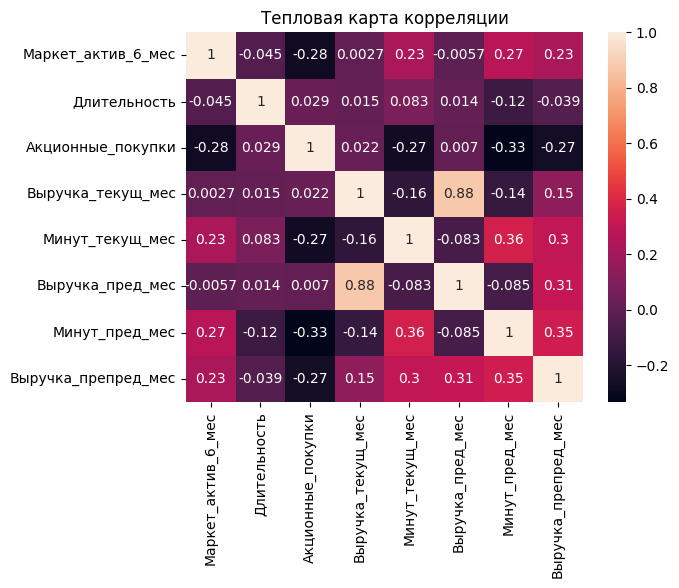

In [110]:
# визуализируем
sns.heatmap(analysis.corr(method= 'spearman'), annot=True)
plt.title('Тепловая карта корреляции')

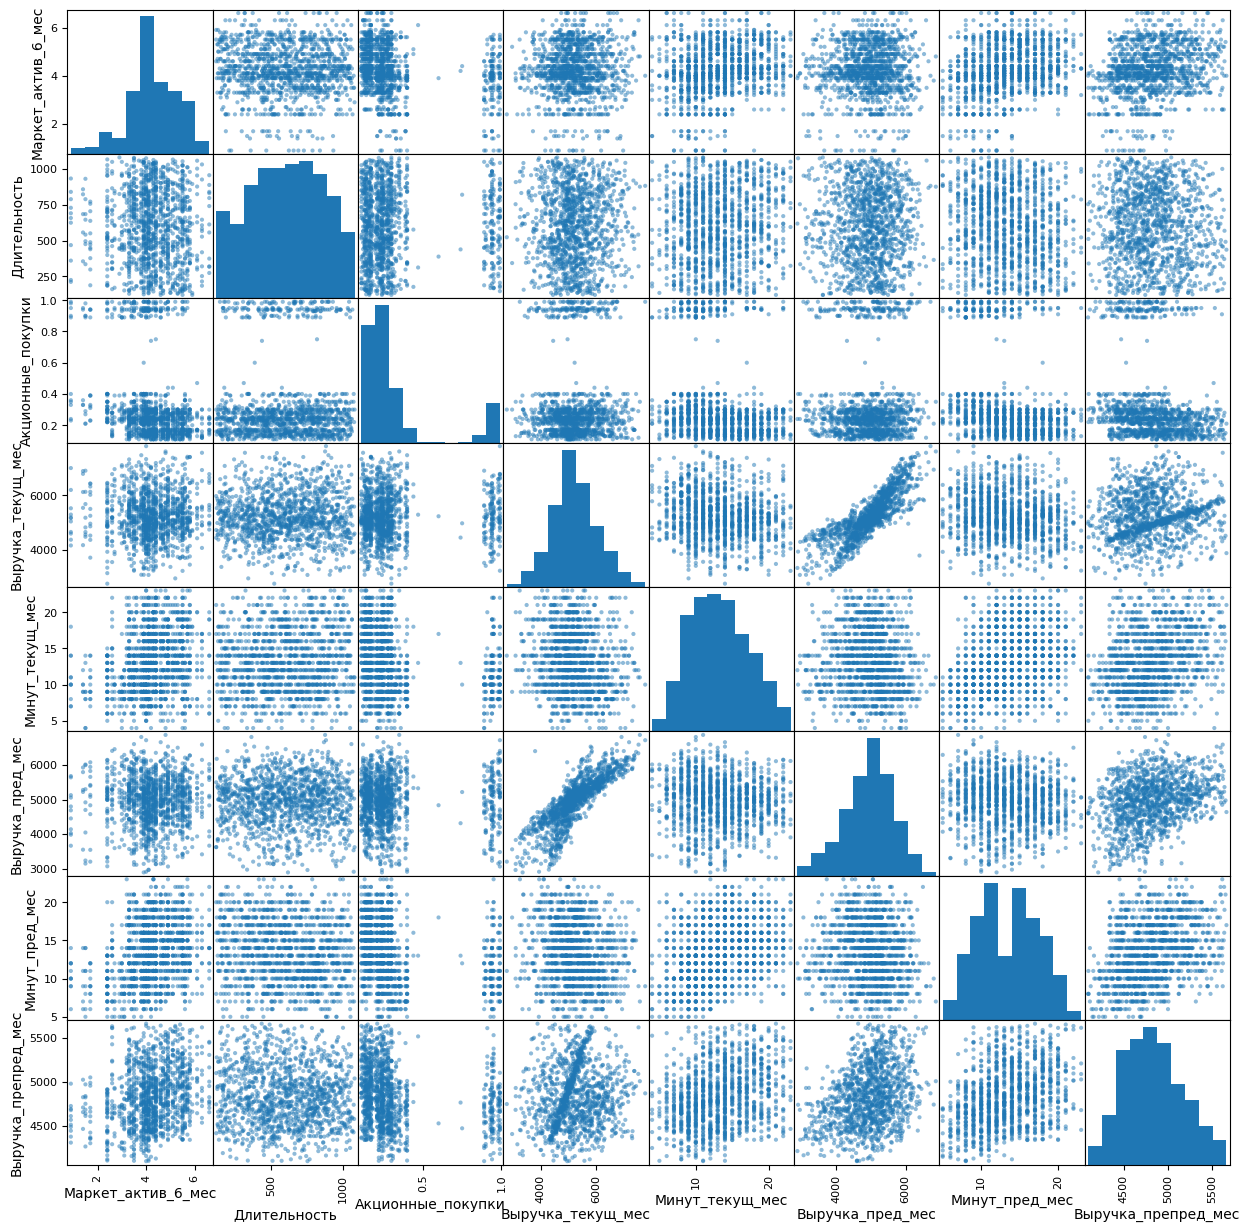

In [111]:
# построим матрицу корреляции
pd.plotting.scatter_matrix(analysis, figsize=(15, 15)) 

plt.show()

**Вывод:** Из полученных данных мы видим, что корреляция между признаками `'Выручка_текущ_мес'` и `'Выручка_пред_мес'` равна 0.88 - значение довольно большое, но не критичное. Можно говорить о том, что в данных нет мультиколлинеарности.

##  Шаг 6. Использование пайплайнов

In [112]:
# проверим данные на дисбаланс классов

market_all['Покупательская_активность'].value_counts(normalize=True)

Покупательская_активность
Прежний уровень   0.62
Снизилась         0.38
Name: proportion, dtype: float64

In [113]:
# разделим данные на выборки

RANDOM_STATE = 42

X = market_all.drop(['Покупательская_активность'], axis=1)
y = market_all['Покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state= RANDOM_STATE, stratify=y
)

In [114]:
# введём обозначения для типов исходных данных

ohe_columns = ['Тип_сервиса','Разрешить_сообщать']

ord_columns = ['Популярная_категория']

num_columns = ['Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки',
               'Выручка_текущ_мес', 'Минут_текущ_мес', 'Минут_пред_мес', 'Выручка_пред_мес', 
               'Выручка_препред_мес', 'Маркет_актив_тек_мес', 'Средний_просмотр_категорий_за_визит',
               'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит'
] 

In [115]:
# переходим к созданию пайплайна

ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', sparse_output=False))
])

ord_pipe = Pipeline([
    ('ord', OrdinalEncoder(categories=[['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары', 
             'Техника для красоты и здоровья', 'Кухонная посуда', 'Мелкая бытовая техника и электроника']]
    ))
])

In [116]:
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', StandardScaler(), num_columns)
]) 

In [117]:
# создаем итоговый пайплайн

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state= RANDOM_STATE))
]) 

In [118]:
# создаем словарь для перебора гиперпараметров моделей

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__kernel': ['linear','rbf', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1',
            class_weight='balanced'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]


In [119]:
# используем инструмент RandomizedSearchCV, т.к. мы сравниваем сразу 4 модели

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['Тип_сервиса',
                                                                                'Разрешить_сообщать']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(categories=[['Товары '
                                                                                                                            'для '
                                                                                                                            'детей',
                                                                                                                            'Домашний '
                                                                                                                            'текстиль',
                                                                                                                            'Косметика '
                                                                                                                            'и '
                                                                                                                            'аксесуары',
                                                                                                                            'Техник...
                                        {'models': [SVC(random_state=42)],
                                         'models__kernel': ['linear', 'rbf',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(class_weight='balanced',
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [120]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Тип_сервиса',
                                                   'Разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['Товары '
                                                                                               'для '
                                                                                               'детей',
                    

Тестирование лучшей модели:

In [121]:
best_model = randomized_search

In [122]:
pred = best_model.best_estimator_.predict(X_test)

In [123]:
pred_prob = best_model.best_estimator_.predict_proba(X_test)[:, 1]

In [124]:
print('Метрика ROC-AUC на тестовой выборке:', roc_auc_score(y_test, pred_prob))

Метрика ROC-AUC на тестовой выборке: 0.9222837425774354


**Вывод:** По итогам подбора моделей лучшие результаты у модели логистической регрессии.

## Шаг 7. Анализ важности признаков

In [125]:
X_train_encoded = best_model.best_estimator_['preprocessor'].fit_transform(X_train)

In [126]:
best_model_encoded = best_model.best_estimator_['models'].fit(X_train_encoded, y_train) 

In [127]:
explainer = shap.Explainer(best_model.best_estimator_['models'], 
                           X_train_encoded, 
                           feature_names=X_train.columns)

In [128]:
shap_values = explainer(X_train_encoded)

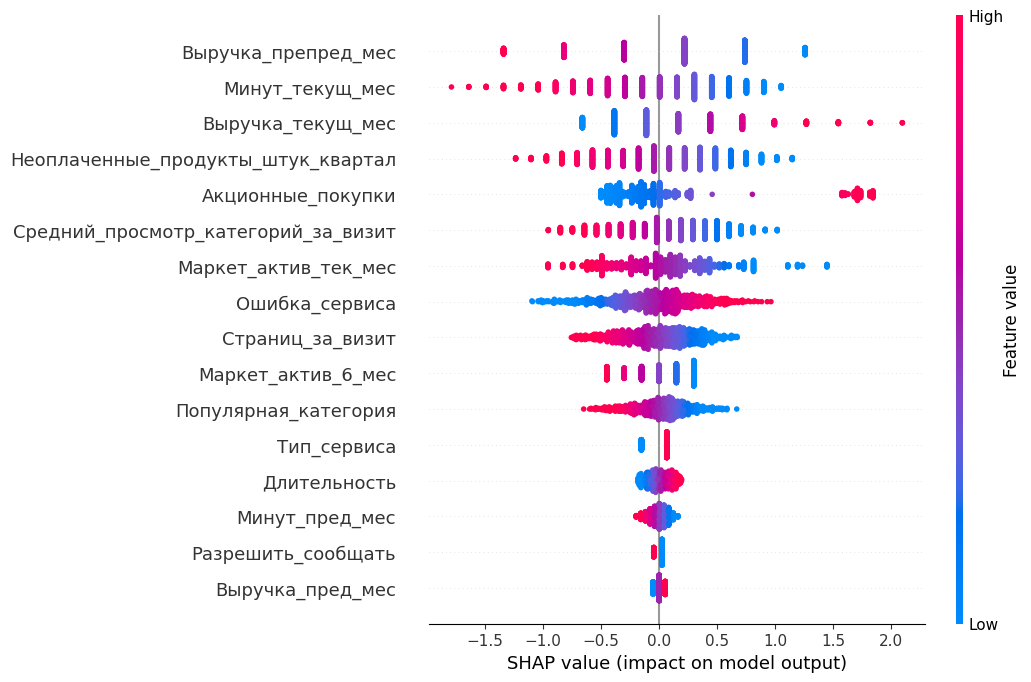

In [129]:
shap.plots.beeswarm(shap_values, max_display=20)

**Вывод:** Самыми малозначимыми для модели оказались признаки `'Выручка_пред_мес'`, `'Разрешить_сообщать'`, `'Минут_пред_мес'`, `'Длительность'`, `'Тип_сервиса'`. То есть на снижение покупательской активности практически не влияет, как клиент покупал в прошлом месяце, давал ли он разрешение на рассылки, сколько времени на сайте он провел в предыдущем месяце, как давно он зарегистрирован на сайте и какой имеет тип сервиса.\
Можно заметить, что сильнее всего на целевой влияют признаки:
- чем меньше клиент покупал в препредыдущем месяце;
- чем меньше времени клиент провел на сайте в текущем месяце, чем меньше страниц и категорий просмотрел за визит;
- чем больше выручки он сделал магазину в текущем месяце;
- чем меньше неоплаченных продуктов он оставил в корзине;
- чем больше клиент покупает по акции и чем больше ошибок он встречает в работе сайта - 

тем сильнее это влияет на снижение покупательской активности.

Можно предложить бизнесу провести апгрейд сайта, разобраться с тем, что "под капотом", чтобы избежать оттока клиентов из-за ошибок на сайте.

Можно посмотреть отдельно на клиентов, которые сделали хорошую выручку магазину в текущем месяце, и при этом их покупательская активность снизилась. 

## Шаг 8. Сегментация покупателей

Чтобы использовать результаты моделирования и данные о прибыльности покупателей, вернемся к тестовой выборке `X_test` и добавим в нее полученные предсказания `pred_prob`

In [130]:
X_test['Вероятность'] = pred_prob

# отсортируем
X_test.sort_values(by= 'Вероятность', ascending= False, inplace= True)

# проверим результат
X_test

,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_пред_мес,Выручка_препред_мес,Выручка_текущ_мес,Минут_пред_мес,Минут_текущ_мес,Вероятность
id,,,,,,,,,,,,,,,,,
215552,стандарт,да,0.90,4,624,0.89,Косметика и аксесуары,1,9,5,1,5678.50,4726.00,6194.60,12,11,1.00
215433,стандарт,да,4.00,4,753,0.89,Товары для детей,2,8,3,2,4599.00,4098.00,4959.10,8,11,1.00
215418,стандарт,нет,1.70,4,472,0.94,Домашний текстиль,2,6,4,3,5943.50,4661.00,6427.10,8,11,1.00
215463,стандарт,нет,3.10,4,472,0.99,Домашний текстиль,2,6,3,3,5196.00,4470.00,5015.30,8,12,1.00
215705,премиум,нет,0.90,4,657,0.99,Домашний текстиль,2,4,2,5,5055.50,4568.00,5522.20,10,7,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216161,стандарт,да,4.10,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3973.00,4912.00,3289.20,16,17,0.02
215838,стандарт,нет,6.30,4,582,0.14,Косметика и аксесуары,5,1,6,13,5193.00,4932.00,5549.20,17,13,0.02
216273,премиум,да,5.70,3,503,0.14,Товары для детей,6,1,4,9,3475.00,4766.00,4724.30,17,14,0.01


Выделим группу клиентов, которые сделали хорошую выручку магазину в текущем месяце, и при этом высока вероятность, что их покупательская активность снизится.

Text(0, 0.5, 'Выручка')

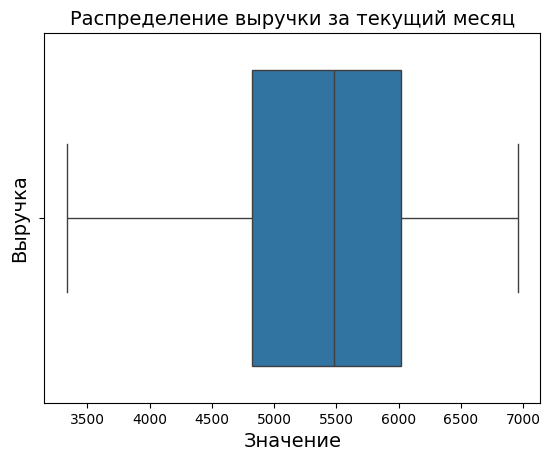

In [131]:
# посмотрим распределение выручки у клиентов с большой вероятностью снижения активности

X_test_gain = X_test.query('Вероятность > 0.5')
boxplot = sns.boxplot(x= X_test_gain['Выручка_текущ_мес'])
boxplot.axes.set_title('Распределение выручки за текущий месяц', fontsize=14)
boxplot.set_xlabel('Значение', fontsize=14)
boxplot.set_ylabel('Выручка', fontsize=14)

Возьмем значение выручки больше или равному 5500

In [132]:
segment = X_test.query('Выручка_текущ_мес >= 5500')
segment.head()

,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_пред_мес,Выручка_препред_мес,Выручка_текущ_мес,Минут_пред_мес,Минут_текущ_мес,Вероятность
id,,,,,,,,,,,,,,,,,
215552,стандарт,да,0.90,4,624,0.89,Косметика и аксесуары,1,9,5,1,5678.50,4726.00,6194.60,12,11,1.00
215418,стандарт,нет,1.70,4,472,0.94,Домашний текстиль,2,6,4,3,5943.50,4661.00,6427.10,8,11,1.00
215705,премиум,нет,0.90,4,657,0.99,Домашний текстиль,2,4,2,5,5055.50,4568.00,5522.20,10,7,1.00
215744,стандарт,да,1.70,5,439,0.31,Кухонная посуда,1,5,2,1,5421.50,4370.00,6016.90,6,9,1.00
215436,стандарт,да,4.60,3,844,0.93,Товары для детей,3,8,4,2,5370.00,4752.00,5511.70,10,10,0.99


Построим график

Ignoring `palette` because no `hue` variable has been assigned.


Text(0.5, 1.0, 'График зависимости вероятности от выручки за текущий месяц')

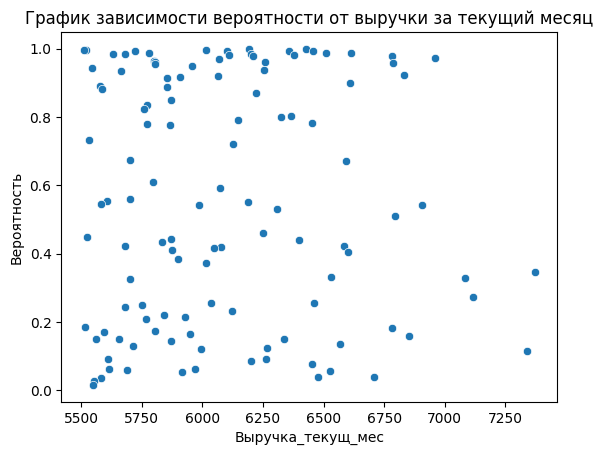

In [133]:
sns.scatterplot(x='Выручка_текущ_мес', y='Вероятность', data= segment, palette='bright')
plt.title('График зависимости вероятности от выручки за текущий месяц')

На графике мы видим, что у клиентов, приносящих выручку более 7000, вероятность снижения активности ниже, чем у остальных.\
Посмотрим другие зависимости этой группы клиентов.

Ignoring `palette` because no `hue` variable has been assigned.


Text(0.5, 1.0, 'График зависимости вероятности от величины выручки за препредыдущий месяц')

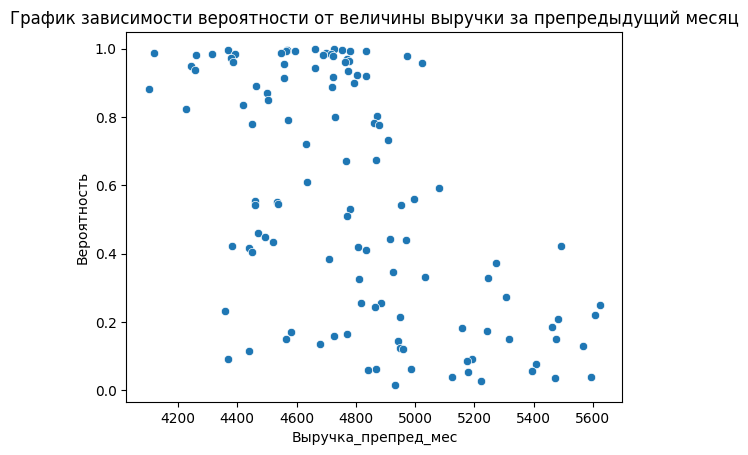

In [134]:
sns.scatterplot(x='Выручка_препред_мес', y='Вероятность', data= segment, palette='bright')
plt.title('График зависимости вероятности от величины выручки за препредыдущий месяц')

Здесь мы видим, что клиенты из этой группы, имеющие низкую вероятность снижения активности, покупали на сумму больше, чем остальные в препредыдущем месяце.

Ignoring `palette` because no `hue` variable has been assigned.


Text(0.5, 1.0, 'График зависимости вероятности от времени на сайте в текущем месяце')

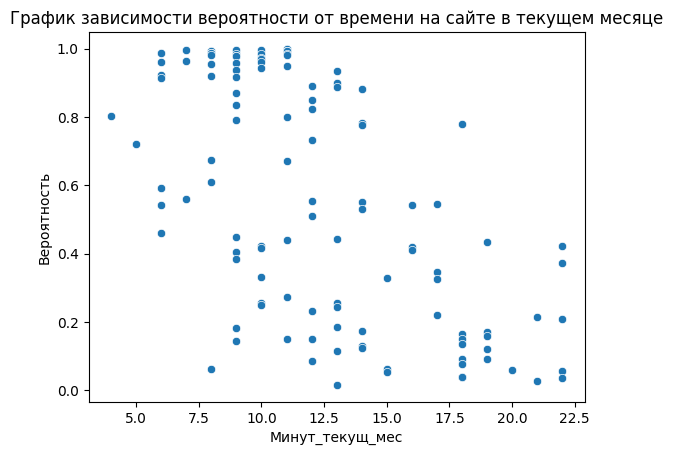

In [135]:
sns.scatterplot(x='Минут_текущ_мес', y='Вероятность', data= segment, palette='bright')
plt.title('График зависимости вероятности от времени на сайте в текущем месяце')

Из этого графика мы видим, что клиенты с высокой вероятностью снижения активности не находятся на сайте дольше 12 минут. В основном они находятся на сайте от 6 до 11 минут. А клиенты с низкой вероятностью снижения активности находятся на сайте от 7.5 до 22 минут.

Ignoring `palette` because no `hue` variable has been assigned.


Text(0.5, 1.0, 'График зависимости вероятности от времени на сайте в предыдущем месяце')

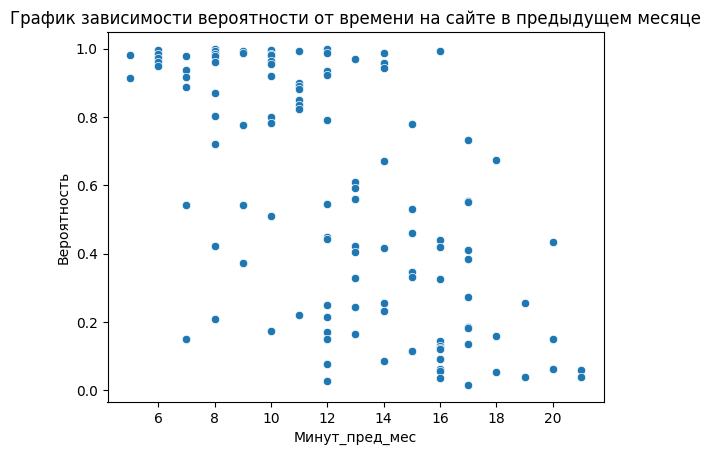

In [136]:
sns.scatterplot(x='Минут_пред_мес', y='Вероятность', data= segment, palette='bright')
plt.title('График зависимости вероятности от времени на сайте в предыдущем месяце')

На этом графике с минутами за предыдущий месяц наблюдается похожая ситуация.

Ignoring `palette` because no `hue` variable has been assigned.


Text(0.5, 1.0, 'График зависимости вероятности от кол-ва посещаемых страниц за визит')

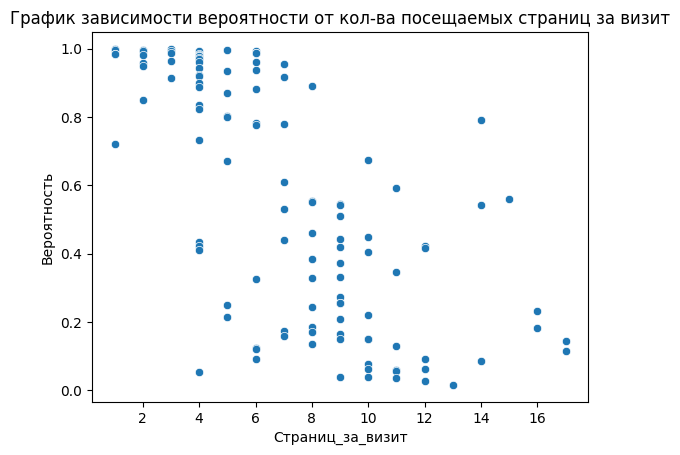

In [137]:
sns.scatterplot(x='Страниц_за_визит', y='Вероятность', data= segment, palette='bright')
plt.title('График зависимости вероятности от кол-ва посещаемых страниц за визит')

А на этом графике мы видим, что наши выделенные клиенты, у которых высока вероятность снижения активности, просматривают до 8 страниц за визит. Большинство же клиентов с низкой вероятностью снижения активности просматривают 8 и более страниц за визит.

Ignoring `palette` because no `hue` variable has been assigned.


Text(0.5, 1.0, 'График зависимости вероятности от маркетинговой активности за последние 6 месяцев')

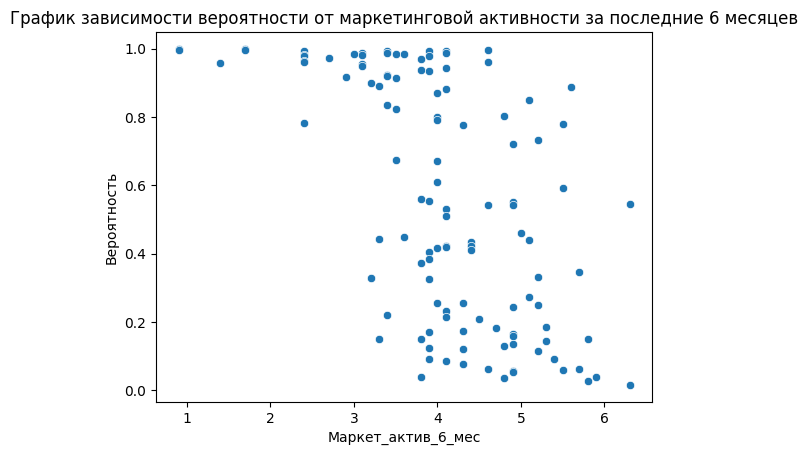

In [138]:
sns.scatterplot(x='Маркет_актив_6_мес', y='Вероятность', data= segment, palette='bright')
plt.title('График зависимости вероятности от маркетинговой активности за последние 6 месяцев')

Зависимость, которую нам удалось выявить: с клиентами, сделавшими большую выручку и имеющими большую вероятность снижения активности, проводилось в основном меньше 4х маркетинговых коммуникаций в месяц. Клиенты, с которыми проводилось от 4 до 6 коммуникаций, имеют меньшую вероятность снижения активности.

**Вывод:** На данном этапе мы провели сегментацию покупателей, исходя из результатов моделирования. Мы ранжировали клиентов по вероятности снижения активности и выбрали для исследования группу клиентов, которые сделали хорошую выручку магазину в текущем месяце, и при этом их покупательская активность снизилась: важно найти причины, по которым это произошло.\
Из полученных результатов и графиков можно заметить следующее:
- клиенты из этой группы, имеющие низкую вероятность снижения активности, покупали на сумму больше, чем остальные в текущем и препредыдущем месяце;
- клиенты с высокой вероятностью снижения активности находились на сайте в основном меньше, чем остальные как в текущем, так и в предыдущем месяце;
- клиенты, у которых высока вероятность снижения активности, просматривают меньше страниц за визит, чем остальные;
- с клиентами, сделавшими большую выручку и имеющими большую вероятность снижения активности, проводилось в основном меньше 4х маркетинговых коммуникаций в месяц. Клиенты, с которыми проводилось от 4 до 6 коммуникаций, имеют меньшую вероятность снижения активности.

Из этого мы можем предположить и рекомендовать:
- Покупатели заранее определились со своими покупками и на сайте вели себя целенаправленно. Для таких клиентов можно сформировать маркетинговые предложения на основе их покупок и показать, что ещё есть интересного на сайте, что, возможно, они могли не заметить.
- Покупатели провели меньше времени на сайте и просмотрели меньше категорий, на это могли повлиять ошибки сервиса, можно обратиться к специалисту, чтобы в дальнейшем возникало меньше ошибок.
- Формировать и проводить больше маркетинговых коммуникаций.

## Шаг 9. Общий вывод

Целью данного исследования была разработка решения, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Первым этапом была выполнена работа по ознакомлению с данными и их предобработке. В нашем распоряжеии было четыре таблицы: 
- с данными о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении,
- с данными о выручке, которую получает магазин с покупателя,
- с данными о времени, которое покупатель провёл на сайте в течение периода,
- с данными о среднемесячной прибыли покупателя за последние три месяца.

Следующим этапом нами был проведен исследовательский анализ данных.

В ходе исследования количественных и категориальных признаков было выявлено:
- В среднем магазином проводится около 4 маркетинговых коммуникаций с покупателем в месяц, редко магазин ограничивается 1-2 коммуникациями. Маркетинговые коммуникации имеют нормальное распределение.
- Больше всего покупателей являются клиентами этого сайта от 1 до 2 лет.
- Доля акционных покупок составляет около 25%. 
- За 1 визит покупатели просматривают в основном от 2 до 4 категорий товаров. 
- Большинство покупателей оставляют 1-2 неоплаченных товара в корзине, около половины покупателей оплачивают все товары, и только 1% покупателей оставляют неоплаченными 9-10 товаров.
- Всего лишь 1.3% посещений обходится без сбоев на сайте, обычно от 3 до 5 сбоев - это норма.
- Покупательская активность осталась на преждем уровне у 61.7% покупателей. Снижение наблюдаем в 38.3% случаев, это не критично, но, тем не менее, много.
- Из популярных категорий у покупателей лидируют товары для детей (25.4%) и домашний текстиль (19.3%).

Также на данном этапе мы выделили несколько групп покупателей:
- С покупательской активностью не менее трёх месяцев. Ими оказалось подавляющее большинство: все клиенты, за исключением нескольких человек делали покупки в течение трех месяцев.
- С максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности: ими оказались 10% от всех клиентов.
- С высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью: таких покупателей оказалось 20%.
- Клиенты, которые покупают товары с длинным жизненным циклом: это 6% от всего количества.

После этого мы перешли к созданию и обучению модели для задачи классификации.

Следующей нашей задачей стал анализ важности признаков лучшей модели.\
Можно заметить, что сильнее всего на целевой влияют признаки:
- чем меньше клиент покупал в препредыдущем месяце;
- чем меньше времени клиент провел на сайте в текущем месяце, чем меньше страниц и категорий просмотрел за визит;
- чем больше выручки он сделал магазину в текущем месяце;
- чем меньше неоплаченных продуктов он оставил в корзине;
- чем больше клиент покупает по акции и чем больше ошибок он встречает в работе сайта - 

тем сильнее это влияет на снижение покупательской активности.

Можно предложить бизнесу провести апгрейд сайта, разобраться с тем, что "под капотом", чтобы избежать оттока клиентов из-за ошибок на сайте.

На основании результатов анализа важности признаков мы провели сегментацию клиентов и выбрали группу клиентов, которые сделали хорошую выручку магазину в текущем месяце, и при этом их покупательская активность снизилась. 

Из полученных результатов и графиков можно заметить следующее:
- клиенты из этой группы, имеющие низкую вероятность снижения активности, покупали на сумму больше, чем остальные в текущем и препредыдущем месяце;
- клиенты с высокой вероятностью снижения активности находились на сайте в основном меньше, чем остальные как в текущем, так и в предыдущем месяце;
- клиенты, у которых высока вероятность снижения активности, просматривают меньше страниц за визит, чем остальные;
- с клиентами, сделавшими большую выручку и имеющими большую вероятность снижения активности, проводилось в основном меньше 4х маркетинговых коммуникаций в месяц. Клиенты, с которыми проводилось от 4 до 6 коммуникаций, имеют меньшую вероятность снижения активности.

Из этого мы можем предположить и рекомендовать:
- Покупатели заранее определились со своими покупками и на сайте вели себя целенаправленно. Для таких клиентов можно сформировать маркетинговые предложения на основе их покупок и показать, что ещё есть интересного на сайте, что, возможно, они могли не заметить.
- Покупатели провели меньше времени на сайте и просмотрели меньше категорий, на это могли повлиять ошибки сервиса, можно обратиться к специалисту, чтобы в дальнейшем возникало меньше ошибок.
- Формировать и проводить больше маркетинговых коммуникаций.